# Proyek Klasifikasi Gambar: [Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)
- **Nama:** Ikrar Bagaskara
- **Email:** ikrarb95@gmail.com
- **ID Dicoding:** ikrar557

### Penerapan Saran

| No | Saran                                                                                       | Status     | Keterangan                                                                 |
|----|-----------------------------------------------------------------------------------------------|------------|-----------------------------------------------------------------------------|
| 1  | Mengimplementasikan Callback                                                                  | ✅  | Menggunakan `ModelCheckpoint`, `EarlyStopping`, `ReduceLROnPlateau`, dan custom callback `AccuracyThresholdCallback`. |
| 2  | Gambar-gambar pada dataset asli memiliki resolusi yang tidak seragam (Tanpa preprocessing)    | ✅  | Dataset Intel Image Classification memiliki ukuran gambar bervariasi sebelum resizing. |
| 3  | Dataset yang digunakan berisi minimal 10.000 gambar                                           | ✅  | Dataset telah di-split dan total gambar >10.000. |
| 4  | Akurasi pada training set dan testing set minimal 95%                                         | ❌     | Akurasi training dan testing masih di bawah 95%. Mentok di 93% euy |
| 5  | Memiliki 3 buah kelas atau lebih                                                              | ✅  | Dataset memiliki 6 kelas: buildings, forest, glacier, mountain, sea, dan street. |
| 6  | Melakukan inference menggunakan salah satu model (TF-Lite, TFJS atau SavedModel)              | ✅  | Inference berhasil dilakukan dari model pada SavedModel untuk setiap kelas |


## Import Semua Packages/Library yang Digunakan

In [1]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report


In [2]:
# # Libraries untuk pemrosesan data gambar
from PIL import Image

In [3]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [38]:
# # Libraries untuk pembangunan model
import tensorflowjs as tfjs
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Activation, TFSMLayer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
print(tf.__version__)

2.18.0


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
os.makedirs("tfjs_model", exist_ok=True)
os.makedirs("tflite", exist_ok=True)

## Data Preparation

In [ ]:
from google.colab import files

files.upload()

### Data Loading

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip -o intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [11]:
old_folder = ['seg_train', 'seg_test', 'seg_pred']
dataset_folder = 'dataset'

os.makedirs(dataset_folder, exist_ok=True)

for folder in old_folder:
    if os.path.exists(folder):
        shutil.move(folder, os.path.join(dataset_folder, folder))
        print(f"Moved '{folder}' to '{dataset_folder}/'")
    else:
        print(f"Folder '{folder}' not found.")

Moved 'seg_train' to 'dataset/'
Moved 'seg_test' to 'dataset/'
Moved 'seg_pred' to 'dataset/'


In [12]:
base_path = 'dataset'
target_folders = ['seg_train', 'seg_test', 'seg_pred']

for folder in target_folders:
    outer_path = os.path.join(base_path, folder)
    inner_path = os.path.join(outer_path, folder)

    if os.path.exists(inner_path):
        print(f"Fixing nested folder in: {folder}")
        for item in os.listdir(inner_path):
            src = os.path.join(inner_path, item)
            dst = os.path.join(outer_path, item)
            if not os.path.exists(dst):
                shutil.move(src, dst)
        os.rmdir(inner_path)
    else:
        print(f"No nested folder in: {folder}")

Fixing nested folder in: seg_train
Fixing nested folder in: seg_test
Fixing nested folder in: seg_pred


## Data Exploration

In [13]:
def count_images(folder_path):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                count += 1
    return count

for folder in old_folder:
    full_path = os.path.join(dataset_folder, folder)
    if os.path.exists(full_path):
        image_count = count_images(full_path)
        print(f"{folder}: {image_count} images")
    else:
        print(f"{folder} not found.")

seg_train: 14034 images
seg_test: 3000 images
seg_pred: 7301 images


In [14]:
print("Classes found:")
print(os.listdir("dataset/seg_train"))

Classes found:
['sea', 'buildings', 'street', 'glacier', 'mountain', 'forest']


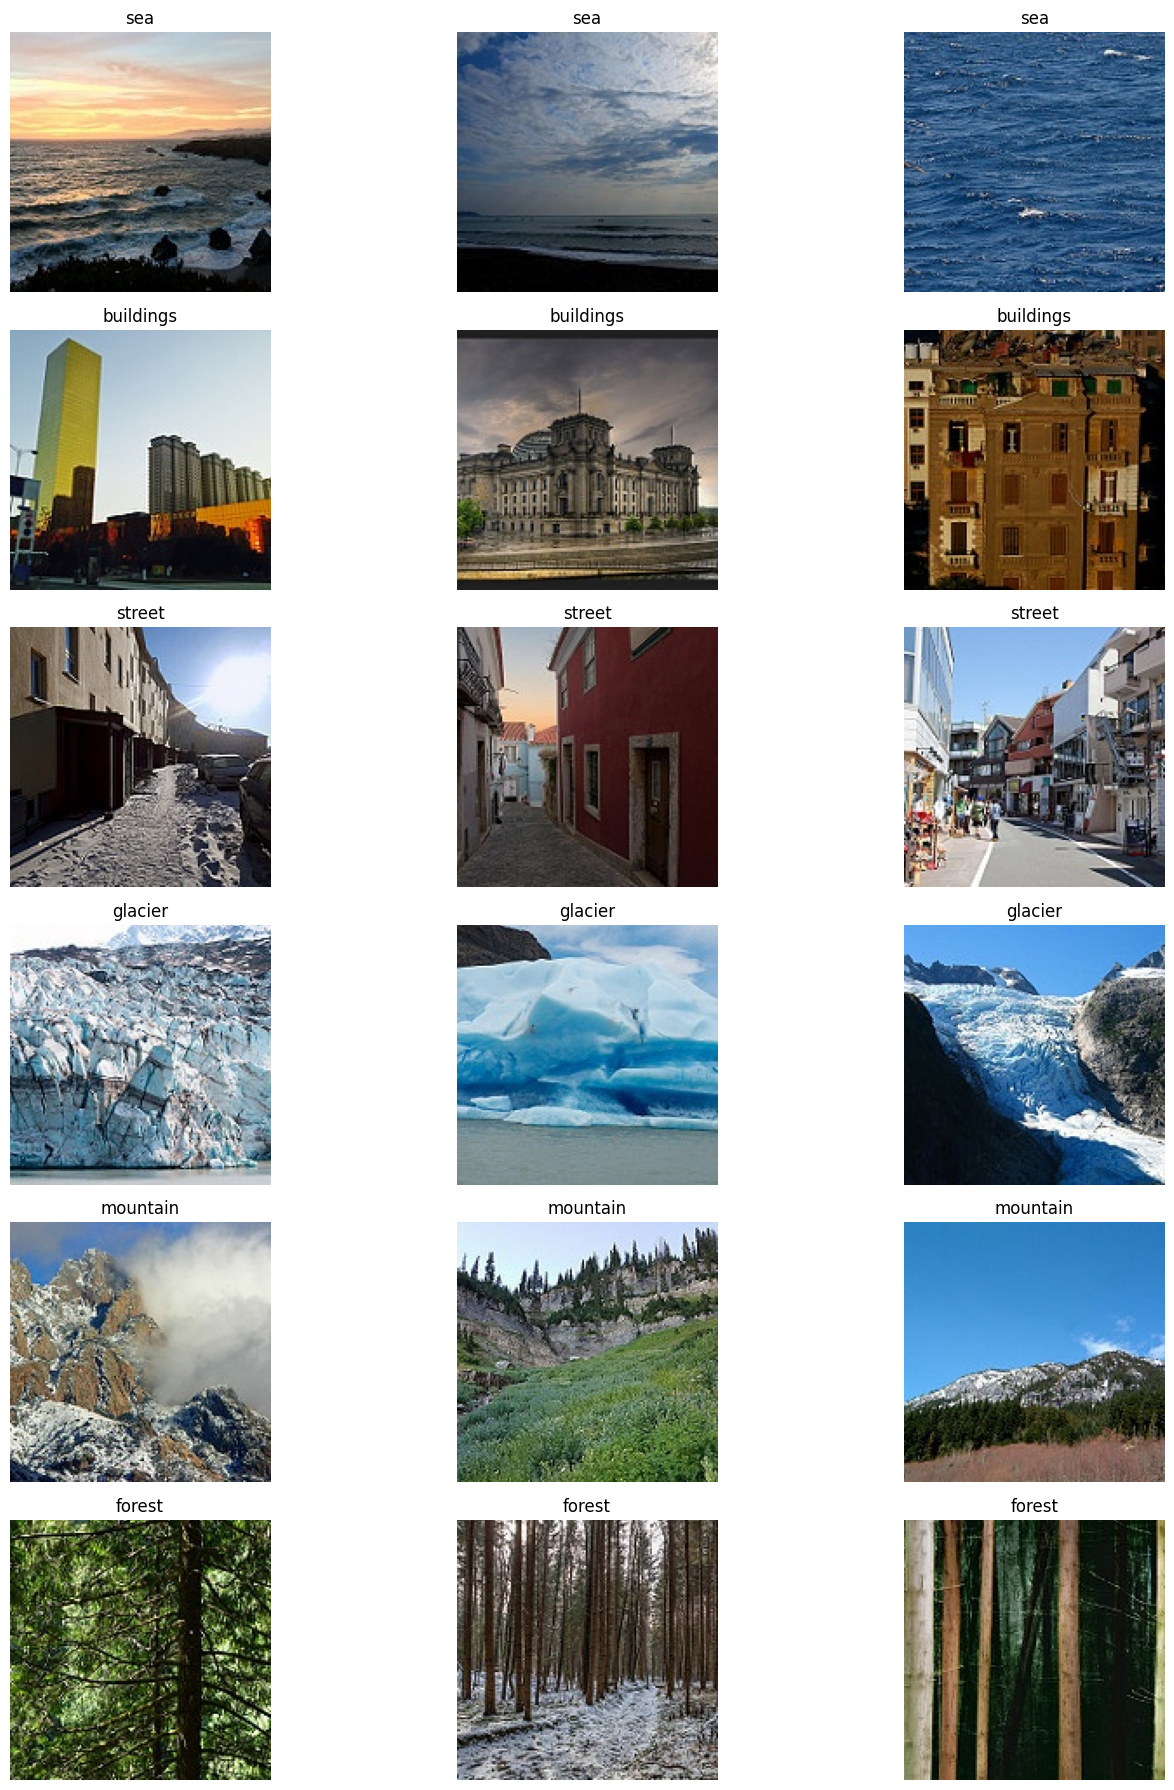

In [15]:
def show_random_images(data_dir, images_per_class=3):
    classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))]

    plt.figure(figsize=(15, len(classes) * 3))

    for row, class_name in enumerate(classes):
        class_path = os.path.join(data_dir, class_name)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

        if len(image_files) >= images_per_class:
            images = random.sample(image_files, images_per_class)
        else:
            images = image_files

        for col, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = mpimg.imread(img_path)
            plt.subplot(len(classes), images_per_class, row * images_per_class + col + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(class_name)

    plt.tight_layout()
    plt.show()

show_random_images("dataset/seg_train")

Image Count per Class:

sea: 2274 images
buildings: 2191 images
street: 2382 images
glacier: 2404 images
mountain: 2512 images
forest: 2271 images


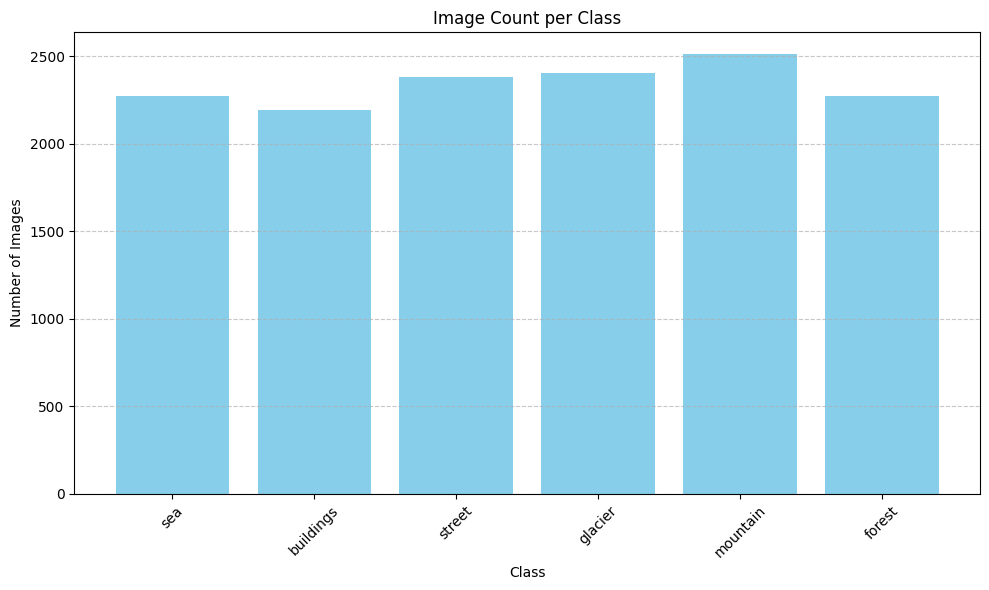

In [16]:
data_train = "dataset/seg_train"
class_counts = {}

for class_name in os.listdir(data_train):
    class_path = os.path.join(data_train, class_name)
    if os.path.isdir(class_path):
        num_images = len([
            file for file in os.listdir(class_path)
            if file.lower().endswith(('.jpg', '.png', '.jpeg'))
        ])
        class_counts[class_name] = num_images

print("Image Count per Class:\n")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Image Count per Class")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [17]:
def analyze_dataset_images(directory, valid_exts=('.jpg', '.jpeg', '.png')):
    total_images = 0

    print("📊 Image resolution analysis per class:\n")

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            unique_sizes = set()
            image_count = 0

            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(valid_exts):
                    img_path = os.path.join(class_path, img_name)
                    try:
                        with Image.open(img_path) as img:
                            unique_sizes.add(img.size)
                            image_count += 1
                    except Exception as e:
                        print(f"⚠️ Error reading {img_path}: {e}")

            print(f"📁 {class_name}: {image_count} images")
            for size in sorted(unique_sizes):
                print(f"  - Size: {size}")
            print("---------------")

            total_images += image_count

    print(f"\n✅ Total valid images: {total_images}")

# Contoh penggunaan
analyze_dataset_images("dataset/seg_train")


📊 Image resolution analysis per class:

📁 sea: 2274 images
  - Size: (150, 113)
  - Size: (150, 140)
  - Size: (150, 150)
---------------
📁 buildings: 2191 images
  - Size: (150, 124)
  - Size: (150, 150)
---------------
📁 street: 2382 images
  - Size: (150, 113)
  - Size: (150, 150)
---------------
📁 glacier: 2404 images
  - Size: (150, 76)
  - Size: (150, 97)
  - Size: (150, 102)
  - Size: (150, 105)
  - Size: (150, 110)
  - Size: (150, 111)
  - Size: (150, 119)
  - Size: (150, 120)
  - Size: (150, 123)
  - Size: (150, 134)
  - Size: (150, 135)
  - Size: (150, 142)
  - Size: (150, 143)
  - Size: (150, 146)
  - Size: (150, 149)
  - Size: (150, 150)
---------------
📁 mountain: 2512 images
  - Size: (150, 81)
  - Size: (150, 100)
  - Size: (150, 103)
  - Size: (150, 113)
  - Size: (150, 123)
  - Size: (150, 131)
  - Size: (150, 134)
  - Size: (150, 135)
  - Size: (150, 136)
  - Size: (150, 141)
  - Size: (150, 142)
  - Size: (150, 143)
  - Size: (150, 144)
  - Size: (150, 145)
  - Size:

#### Terlihat pada output diatas, dataset yang digunakan memiliki resolusi yang tidak sama walau widht nya sama

### Data Preprocessing

#### Split Dataset

In [18]:
original_dataset = "dataset/seg_train"
split_base_dir = "data_split"
splits = ['train', 'val', 'test']
split_ratio = [0.7, 0.15, 0.15]

for split in splits:
    split_path = os.path.join(split_base_dir, split)
    os.makedirs(split_path, exist_ok=True)

for class_name in os.listdir(original_dataset):
    class_path = os.path.join(original_dataset, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        total = len(images)
        train_end = int(split_ratio[0] * total)
        val_end = train_end + int(split_ratio[1] * total)

        split_images = {
            'train': images[:train_end],
            'val': images[train_end:val_end],
            'test': images[val_end:]
        }

        for split in splits:
            split_class_dir = os.path.join(split_base_dir, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for img_name in split_images[split]:
                src_path = os.path.join(class_path, img_name)
                dst_path = os.path.join(split_class_dir, img_name)
                shutil.copy2(src_path, dst_path)

print("Dataset split complete!")


Dataset split complete!


In [19]:
split_base_dir = "data_split"
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest'
)


val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(split_base_dir, "train"),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, "val"),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, "test"),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Found 9820 images belonging to 6 classes.
Found 2102 images belonging to 6 classes.
Found 2112 images belonging to 6 classes.


#### Callbacks

In [25]:
earlystop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

class AccuracyThresholdCallback(Callback):
    def __init__(self, train_threshold=0.95, val_threshold=0.95):
        super().__init__()
        self.train_threshold = train_threshold
        self.val_threshold = val_threshold

    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get("accuracy")
        val_acc = logs.get("val_accuracy")

        if train_acc is not None and val_acc is not None:
            if train_acc >= self.train_threshold and val_acc >= self.val_threshold:
                print(f"\n✅ Reached {self.train_threshold*100:.0f}% accuracy on both training and validation. Stopping training.")
                self.model.stop_training = True

callbacks = [
    AccuracyThresholdCallback(train_threshold=0.95, val_threshold=0.95),
    earlystop,
    reduce_lr
]

## Modelling

In [26]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg_base.trainable = False

model = Sequential([
    vgg_base,

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dropout(0.5),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 4, 64)       │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,044,102 (57.39 MB)

 Trainable params: 329,030 (1.26 MB)

 Non-trainable params: 14,715,072 (56.13 MB)

In [27]:
history = model.fit(
    train_generator,
    epochs=40,
    batch_size=64,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/40
307/307 ━━━━━━━━━━━━━━━━━━━━ 79s 240ms/step - accuracy: 0.4626 - loss: 1.3472 - val_accuracy: 0.8135 - val_loss: 0.5966 - learning_rate: 1.0000e-04
Epoch 2/40
307/307 ━━━━━━━━━━━━━━━━━━━━ 75s 244ms/step - accuracy: 0.7715 - loss: 0.6488 - val_accuracy: 0.8325 - val_loss: 0.4526 - learning_rate: 1.0000e-04
Epoch 3/40
307/307 ━━━━━━━━━━━━━━━━━━━━ 72s 234ms/step - accuracy: 0.8052 - loss: 0.5487 - val_accuracy: 0.8487 - val_loss: 0.4071 - learning_rate: 1.0000e-04
Epoch 4/40
307/307 ━━━━━━━━━━━━━━━━━━━━ 71s 231ms/step - accuracy: 0.8243 - loss: 0.4962 - val_accuracy: 0.8554 - val_loss: 0.3853 - learning_rate: 1.0000e-04
Epoch 5/40
307/307 ━━━━━━━━━━━━━━━━━━━━ 70s 228ms/step - accuracy: 0.8425 - loss: 0.4421 - val_accuracy: 0.8568 - val_loss: 0.3822 - learning_rate: 1.0000e-04
Epoch 6/40
307/307 ━━━━━━━━━━━━━━━━━━━━ 71s 231ms/step - accuracy: 0.8412 - loss: 0.4449 - val_accuracy: 0.8616 - val_loss: 0.3669 - learning_rate: 1.0000e-04
Epoch 7/40
307/307 ━━━━━━━━━━━━━━━━━━━━ 72s 23

## Evaluasi dan Visualisasi

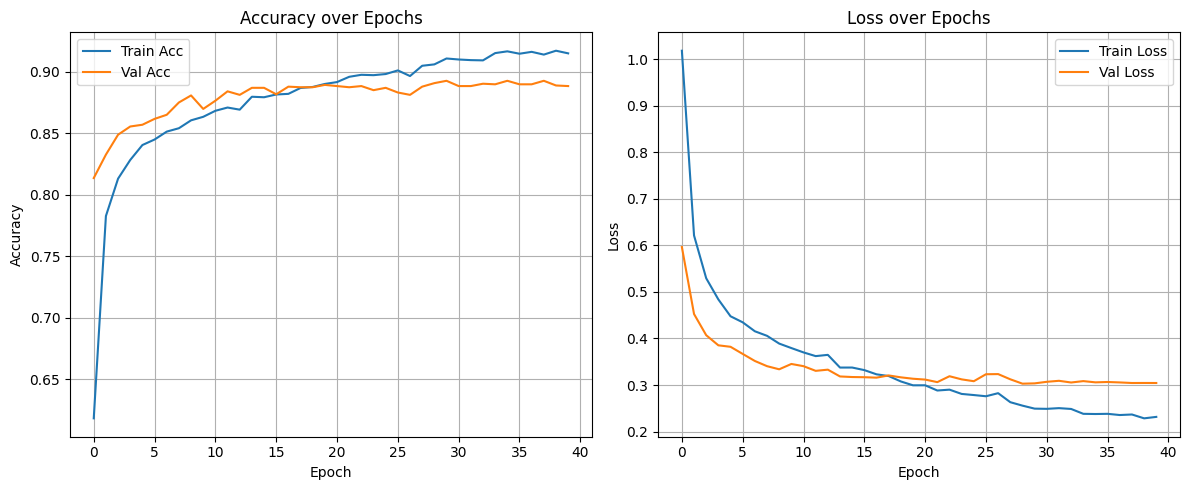

In [28]:
# Akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

2112/2112 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step


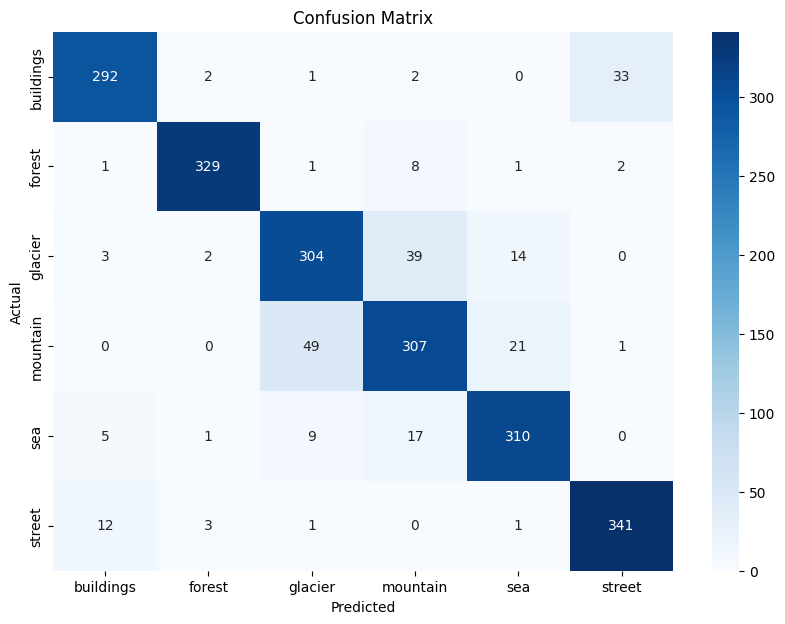

Classification Report:
               precision    recall  f1-score   support

   buildings       0.93      0.88      0.91       330
      forest       0.98      0.96      0.97       342
     glacier       0.83      0.84      0.84       362
    mountain       0.82      0.81      0.82       378
         sea       0.89      0.91      0.90       342
      street       0.90      0.95      0.93       358

    accuracy                           0.89      2112
   macro avg       0.89      0.89      0.89      2112
weighted avg       0.89      0.89      0.89      2112



In [29]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)

class_names = list(test_generator.class_indices.keys())

plot_confusion_matrix(cm, class_names)

report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)


## Konversi Model

In [33]:
model.export("saved_model")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_50')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  136804599872784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804600528528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804600524304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804598944144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804598943568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804598943184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804598945296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804598941456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804598942800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804598941264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804598942032:

In [34]:
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tflite_converter.convert()

with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)


tfjs.converters.save_keras_model(model, "tfjs_model")

Saved artifact at '/tmp/tmprbu6bxjn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_50')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  136804599872784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804600528528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804600524304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804598944144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804598943568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804598943184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804598945296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804598941456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804598942800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136804598941264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13680459894

failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

In [43]:
saved_model_path = "saved_model"
inference_layer = TFSMLayer(saved_model_path, call_endpoint="serving_default")

model = Sequential([inference_layer])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


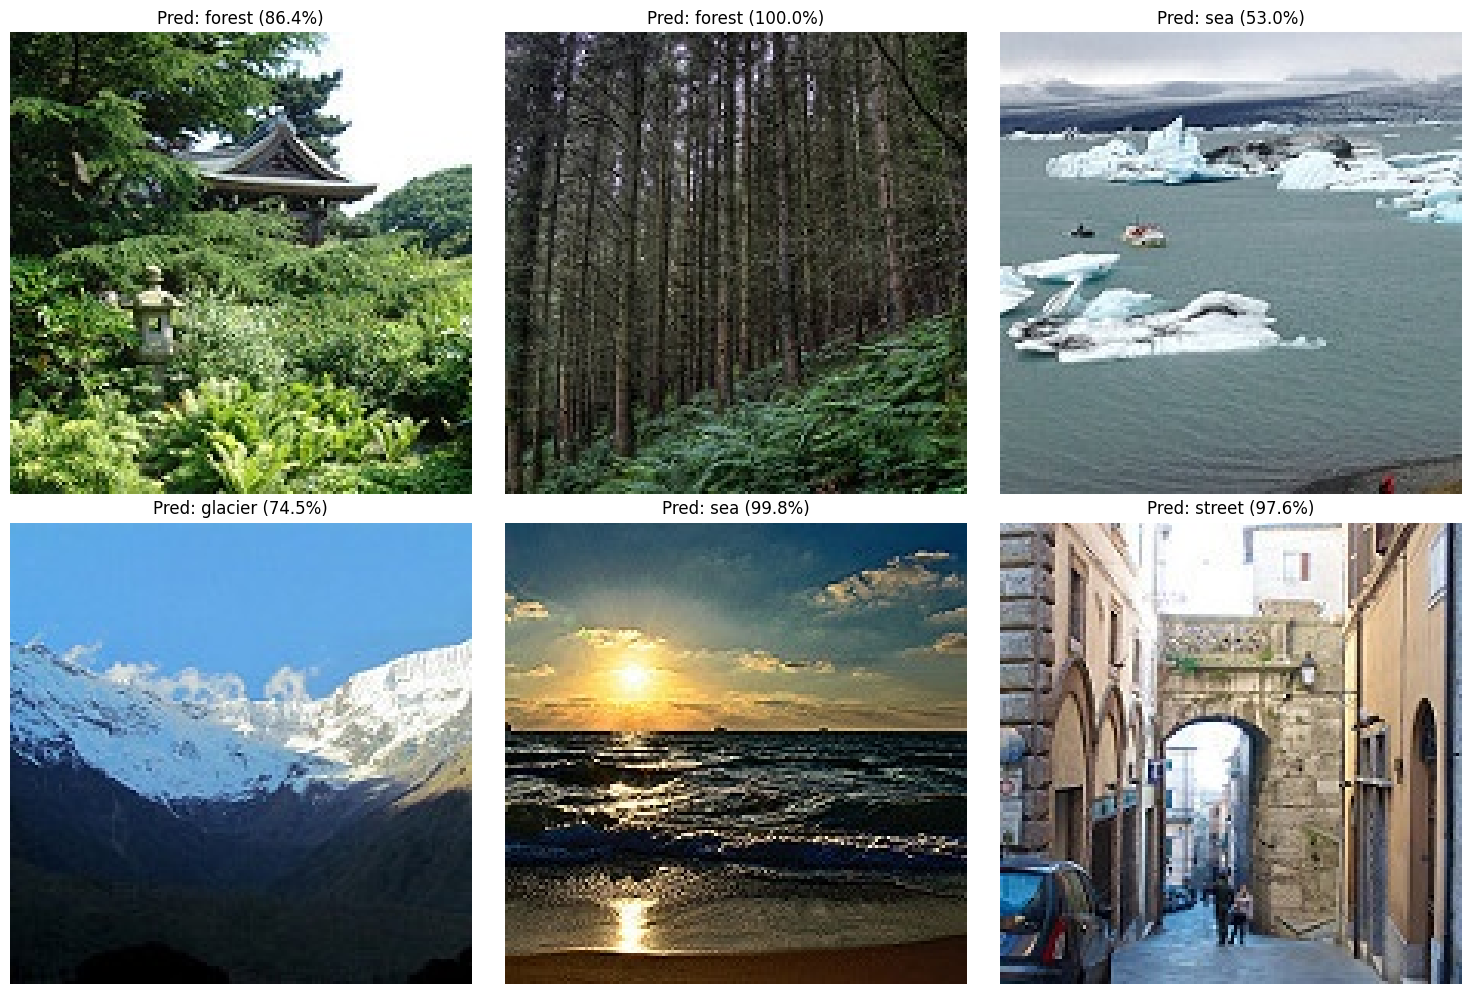

In [47]:

base_dir = "data_split/test"

class_names = sorted(os.listdir(base_dir))

def load_sample_images_per_class(base_dir, target_size=(150, 150)):
    images = []
    labels = []
    class_dirs = sorted(os.listdir(base_dir))

    for class_name in class_dirs:
        class_dir = os.path.join(base_dir, class_name)
        img_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if img_files:
            img_path = os.path.join(class_dir, img_files[0])
            img = image.load_img(img_path, target_size=target_size)
            img_array = image.img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(class_name)

    return np.array(images), labels

# Prediksi
predictions = model.predict(sample_images)
pred_array = predictions['output_0']

predicted_labels = [class_names[np.argmax(p)] for p in pred_array]
confidences = [np.max(p) for p in pred_array]

# Visualisasi
plt.figure(figsize=(15, 10))
for i in range(len(sample_images)):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_images[i])
    plt.axis('off')
    plt.title(f"Pred: {predicted_labels[i]} ({confidences[i]*100:.1f}%)")
plt.tight_layout()
plt.show()
